In [2]:
using DrWatson
quickactivate(@__DIR__)
Base.LOAD_PATH .= findproject(@__DIR__);

import Baysor as B
import BaysorAnalysis as BA

import CairoMakie as MK
import Colors
import Images
import MultivariateStats
import Plots
import CSV
import PyPlot as Plt
import Seaborn as Sns

using Colors
using DataFrames
using DataFramesMeta
using LinearAlgebra
using NearestNeighbors
using ProgressMeter
using Statistics
using StatsBase

ProgressMeter.ijulia_behavior(:clear);
MK.activate!(type = "png");
BA.set_pyplot_defaults!()
cplotsdir(args...) = plotsdir("segmentation", args...);

## Prior segmentation penalties

In [3]:
module T

oversegmentation_penalty(confidence::Float64, fraction::Float64) = 
    (1. - confidence)^0.5 * fraction^confidence

overlap_penalty(confidence::Float64, fraction::Float64) = 
    (1. - confidence)^0.5 * fraction^(confidence * exp(3*confidence))

end

Main.T

In [4]:
Plots.pyplot()

Plots.PyPlotBackend()

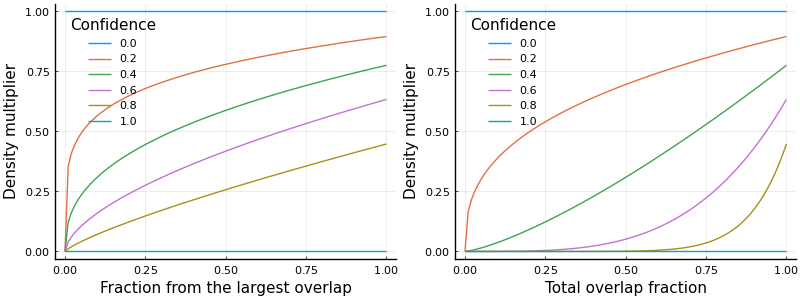

In [6]:
frac_vals = 0.0:0.01:1.0
plt1 = Plots.plot(xlabel="Fraction from the largest overlap", ylabel="Density multiplier", legend=:topleft, legend_title="Confidence", background_legend="#FFFFFF05", legendtitlefonthalign=:hleft)
plt2 = Plots.plot(xlabel="Total overlap fraction", ylabel="Density multiplier", legend=:topleft, legend_title="Confidence", background_legend="#FFFFFF05")
for conf in 0.0:0.2:1.0
    plt1 = Plots.plot!(plt1, frac_vals, T.oversegmentation_penalty.(conf, frac_vals), label="$(conf)")
    plt2 = Plots.plot!(plt2, frac_vals, T.overlap_penalty.(conf, frac_vals), label="$(conf)")
end
plt = Plots.plot(plt1, plt2, size=(800, 300))
Plots.savefig(cplotsdir("prior_segmentation_penalties.pdf"))
Plots.closeall()
plt

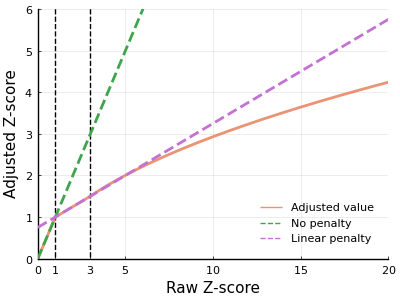

In [8]:
x_vals = 0:0.1:20.0
plt = Plots.plot(widen=false, legend=:bottomright, xlabel="Raw Z-score", ylabel="Adjusted Z-score", size=(400, 300), xticks=vcat(0:5:20, 1, 3))

Plots.vline!([1, 3], label="", color="black", lw=1, line=:dash)
Plots.plot!(x_vals, B.adj_value_norm.(x_vals, 0.0, 1.0), lw=2, alpha=0.75, label="Adjusted value")

t_x = [0, 6]
Plots.plot!(t_x, t_x, line=:dash, label="No penalty", lw=2)
t_x = [0, 20]
Plots.plot!(t_x, 0.25 .* t_x .+ 0.75, line=:dash, label="Linear penalty", lw=2)

Plots.savefig(cplotsdir("expression_penalty.pdf"))
Plots.closeall()
plt

## MERFISH Hypothalamus

In [47]:
@time data = BA.load_merfish(paper_polygons=false, dapi=true, watershed=false, pciseq=false);

 14.955340 seconds (9.41 M allocations: 3.601 GiB, 6.51% gc time)


### Large panel

In [48]:
df_sub = @where(data[:df], :x .>= -3000, :x .<= -2250, :y .<= -2750, :y .>= -3810) |> deepcopy;
df_sub[!, :x_adj] = df_sub.x;
df_sub[!, :y_adj] = df_sub.y;
df_sub[!, :x] = df_sub.x_raw;
df_sub[!, :y] = df_sub.y_raw;

In [27]:
grid_step = 1.0
@time polygons = B.boundary_polygons(df_sub, df_sub.cell, grid_step=grid_step, dens_threshold=1e-3);
length(polygons)

  1.999621 seconds (6.97 M allocations: 1.045 GiB, 24.98% gc time, 5.95% compilation time)


3459

 10.247514 seconds (44.42 M allocations: 1.721 GiB, 3.20% gc time, 1.44% compilation time)


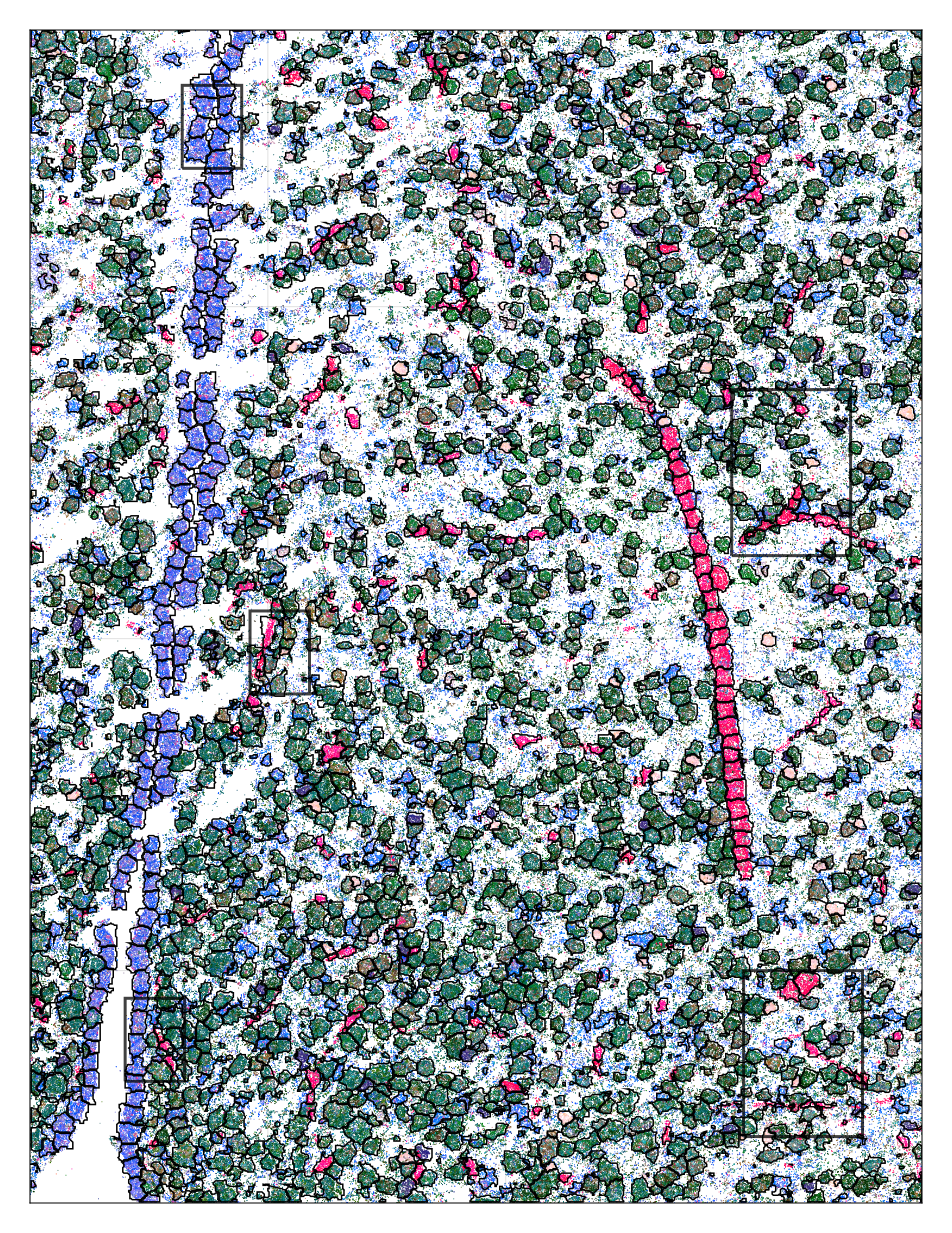

In [46]:
subset_coords = [
    ((-2872, -2822), (-2875, -2800)), 
    ((-2920, -2870), (-3700, -3625)),
    ((-2815, -2765), (-3350, -3275)),
    ((-2400, -2300), (-3750, -3600)),
    ((-2410, -2310), (-3225, -3075))
];

plt = B.plot_dataset_colors(df_sub, :ncv_color; polygons=polygons, min_molecules_per_cell=50, min_pixels_per_cell=7, 
    markersize=1.0, poly_strokewidth=1.5, ticks=false,axis_kwargs=(xticklabelsvisible=false, yticklabelsvisible=false))

for ((xs, xe), (ys, ye)) in subset_coords
    MK.lines!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color=Colors.GrayA(0.0, 0.75), linewidth=3)
end

MK.xlims!(MK.current_axis(), B.val_range(df_sub.x))
MK.ylims!(MK.current_axis(), B.val_range(df_sub.y))

@time MK.save(cplotsdir("merfish_hypothalamus/polygons.png"), plt);
plt

### Zoom-ins

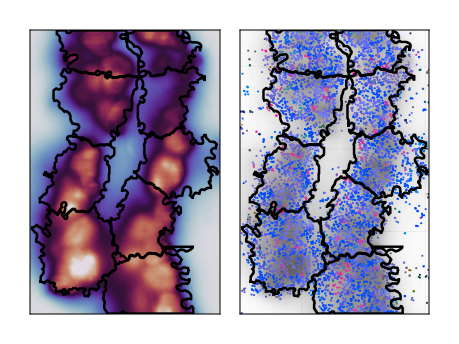

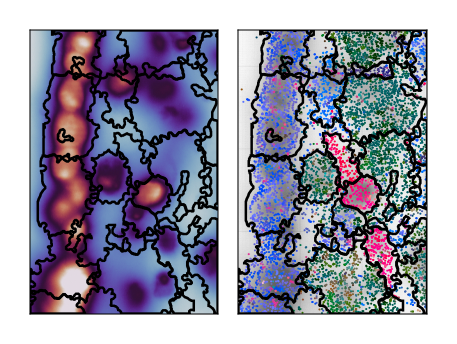

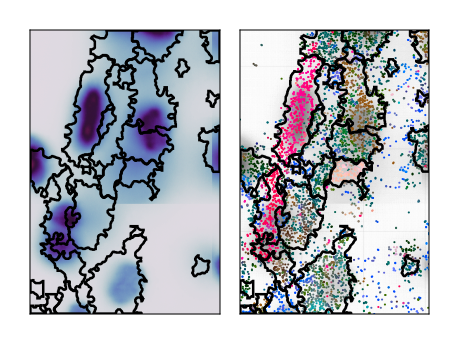

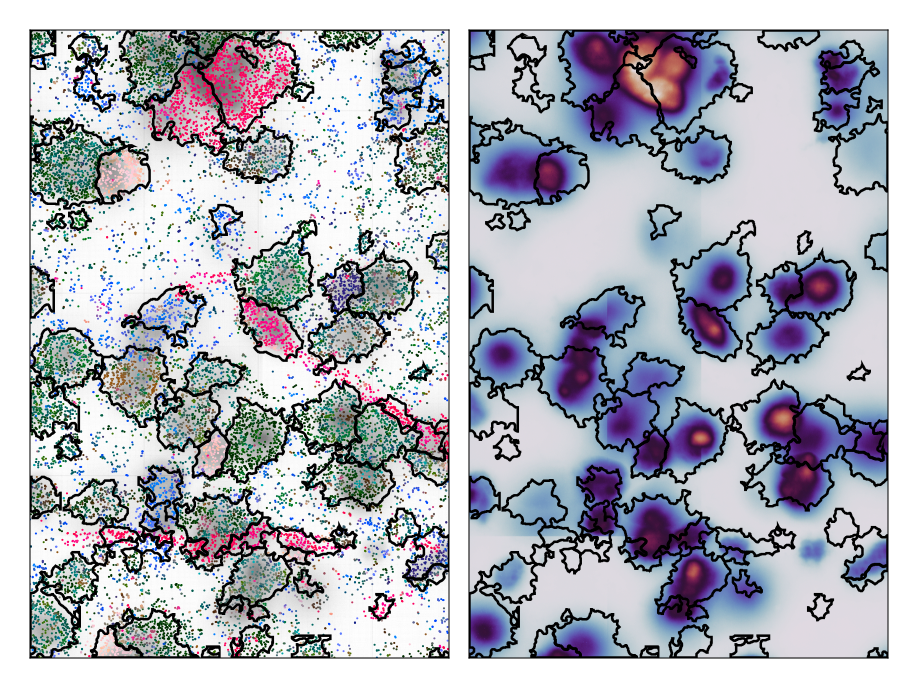

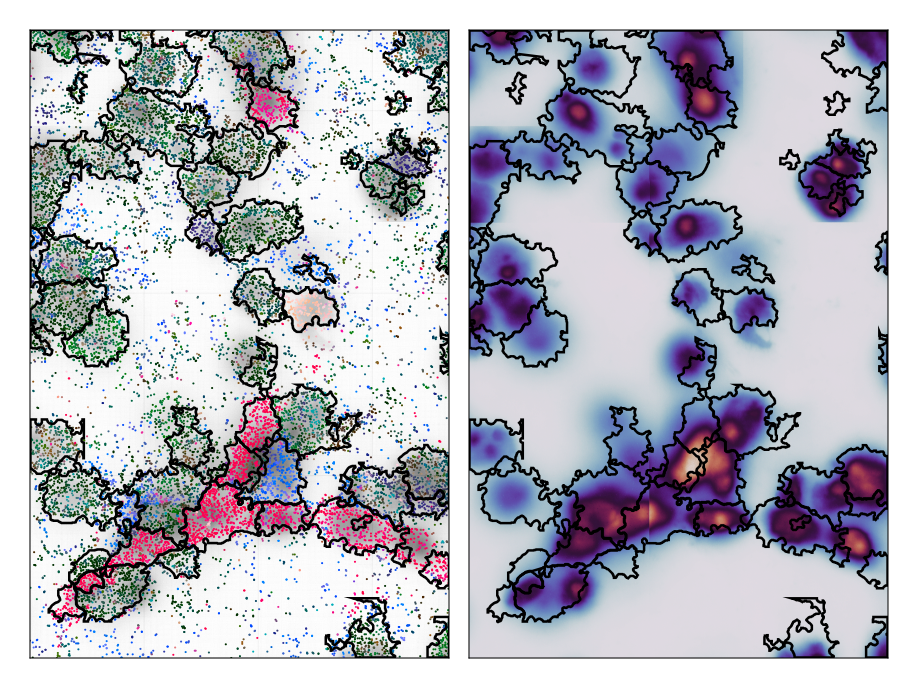

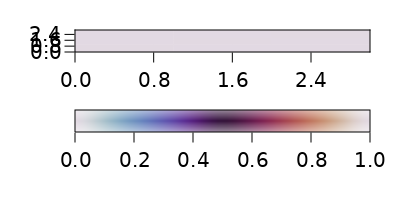

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x00000000324b5ca0, 400.0, 200.0, IOContext(IOStream(<file /home/vpetukhov/spatial/BaysorAnalysis/plots/segmentation/merfish_hypothalamus/legend.pdf>)))


In [126]:
for (i, ((xs, xe), (ys, ye))) in enumerate(subset_coords)
    t_df = @where(data[:df], :x_raw .>= xs, :x_raw .<= xe, :y_raw .>= ys, :y_raw .<= ye)

    plt = BA.plot_subset(data[:df], data[:dapi_arr], B.val_range(t_df.x), B.val_range(t_df.y); size_mult=0.5,
        markersize=2.1, grid_step=1.0, bandwidth=4.0, min_border_length=100, alpha=0.75, polygon_line_width=2.5, swap_plots=(i<=3),
        polygon_alpha=0.7, noise=false, ticks=false, dapi_color=:twilight, clims=(0, 1)) 
    MK.save(cplotsdir("merfish_hypothalamus/example_$i.png"), plt)
    display(plt);
end;

fig = MK.Figure(resolution=(400, 200))
ax = fig[1,1] = MK.Axis(fig)
hm = MK.heatmap!(ax, diagm(0 => ones(3)), colormap=:twilight)
fig[2, 1] = leg = MK.Colorbar(fig, hm, vertical=false, flipaxis=false, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
display(fig)

MK.save(cplotsdir("merfish_hypothalamus/legend.pdf"), fig);

## ISS Hippocampus

In [ ]:
plot_dir = "./plots/iss_hippocampus/";

@time df_spatial, gene_names = B.load_df("../run_results/iss_hippo/ca1_no_prior/segmentation.csv");
df_spatial[!, :cell_dapi] = df_spatial.parent_id;
dapi_arr = Float16.(Images.load("/home/vpetukhov/data/spatal/iss/hippocampus/CA1/Viktor/CA1DapiBoundaries_4-3_right.tif"));

In [ ]:
@time neighb_cm = Baysor.neighborhood_count_matrix(df_spatial, 50);
@time color_transformation = Baysor.gene_composition_transformation(neighb_cm, df_spatial.confidence);

In [ ]:
# @time mtx_trans = Baysor.transform(color_transformation, neighb_cm);
# min_vals = minimum(color_transformation.embedding, dims=2)
# mtx_trans .-= min_vals
# mtx_trans ./= (maximum(color_transformation.embedding, dims=2) - min_vals);

# mtx_colors = deepcopy(mtx_trans)
# mtx_colors[1,:] .*= 100
# mtx_colors[2:3,:] .-= 0.5
# mtx_colors[2:3,:] .*= 200
# gene_colors = vec(mapslices(col -> Colors.Lab(col...), mtx_colors, dims=1));

@time gene_colors = Baysor.gene_composition_colors(neighb_cm, color_transformation);

In [ ]:
df_spatial[!, :color] = gene_colors;

In [ ]:
polygons = Baysor.boundary_polygons(df_spatial, df_spatial.cell, grid_step=1.0, verbose=true, bandwidth=3.0);

In [ ]:
# subset_coords = [((1, 325), (3125, 3440)), ((250, 565), (2860, 3115)), ((630, 970), (3150, 3440)), ((650, 960), (3640, 4000))];
subset_coords = [((270, 550), (2870, 3230)), ((650, 960), (3640, 4000))];

plt = Baysor.plot_dataset_colors(@where(df_spatial, :x .< 2000, :y .> 2500, :y .< 4420), :color, polygons=polygons, min_molecules_per_cell=5,
    min_pixels_per_cell=15, polygon_alpha=0.5, ms=2., alpha=1.0, polygon_line_width=2.5, ticks=false);

for ((xs, xe), (ys, ye)) in subset_coords
    plt = Plots.plot!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color="black", label="", lw=4.0, alpha=1.0)
end

Plots.savefig(plt, "$plot_dir/polygons.png");
Plots.closeall()

plt

In [ ]:
for (i,sc) in enumerate(subset_coords)
    plt = B.plot_subset(df_spatial, dapi_arr, sc...; size_mult=1.0, ms=6.0, grid_step=1.0, bandwidth=2.5, alpha=0.5, polygon_line_width=4.0,
        polygon_alpha=0.7, plot_raw_dapi=false, noise=false, ticks=false, grid=false)
    Plots.savefig(plt, "$plot_dir/example_$i.png")
    display(plt)
    Plots.closeall()
end

## STARmap

In [ ]:
plot_dir = "./plots/star_map_vis_1020/";

@time df_spatial, gene_names = Baysor.load_df("../run_results/star_map/vis_1020_cl0/segmentation.csv");
@show size(df_spatial)

@time dapi_seg_labels = B.load_segmentation_mask("/home/vpetukhov/data/spatal/star_map/visual_1020_20180505_BY3_1kgenes/segmentation.tiff");
df_spatial[!, :cell_dapi] = denserank(B.staining_value_per_transcript(df_spatial, dapi_seg_labels)) .- 1;

dapi_seg_labels = nothing;
GC.gc();

In [ ]:
grid_step = 10.0
polygons = Baysor.boundary_polygons(df_spatial, df_spatial.cell, grid_step=grid_step, verbose=true, bandwidth=10.0);
length(polygons)

In [ ]:
polygons_paper = Baysor.boundary_polygons(df_spatial, df_spatial.cell_dapi, grid_step=grid_step, verbose=true, bandwidth=10.0);

In [ ]:
@time neighb_cm = B.neighborhood_count_matrix(df_spatial, 100, normalize_by_dist=false);
@time color_transformation = B.gene_composition_transformation(neighb_cm, df_spatial.confidence);

In [ ]:
# @time mtx_trans = Baysor.transform(color_transformation, neighb_cm);
# min_vals = minimum(color_transformation.embedding, dims=2)
# mtx_trans .-= min_vals
# mtx_trans ./= (maximum(color_transformation.embedding, dims=2) - min_vals);

# mtx_colors = deepcopy(mtx_trans)
# mtx_colors[1,:] .*= 100
# mtx_colors[2:3,:] .-= 0.5
# mtx_colors[2:3,:] .*= 1000
# gene_colors = vec(mapslices(col -> Colors.Lab(col...), mtx_colors, dims=1));

@time gene_colors = Baysor.gene_composition_colors(neighb_cm, color_transformation);
df_spatial[!, :color] = gene_colors;

### Figure plots

In [ ]:
subset_coords = [((13430, 13850), (5700, 6500)), ((8400, 9050), (3500, 4200))];

plt = Baysor.plot_dataset_colors(@where(df_spatial, :x .>= 7700, :y .>= 0, :y .<= 16000), :color, polygons=polygons, min_molecules_per_cell=50,
    polygon_line_width=2.5, min_pixels_per_cell=15, ms=1.1, alpha=0.9, ticks=false);

for ((xs, xe), (ys, ye)) in subset_coords
    plt = Plots.plot!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color="black", label="", lw=8.0, alpha=1.)
end

@time Plots.savefig(plt, "$plot_dir/polygons.png");
Plots.closeall()
plt

In [ ]:
for (i,sc) in enumerate(subset_coords)
    plt = B.plot_subset(df_spatial, nothing, sc...; size_mult=0.5, ms=3.5, alpha=0.3, polygon_line_width=4.0, 
        polygon_alpha=0.7, plot_raw_dapi=false, noise=false, xticks=false, yticks=false, grid=false, polygons=polygons)
    Plots.savefig(plt, "$plot_dir/example_$i.png")
    display(plt)
    Plots.closeall()
end

### Analyse problems

In [ ]:
pc2 = B.transform(B.fit(MultivariateStats.PCA, neighb_cm, maxoutdim=2), neighb_cm);
sample_ids = B.select_ids_uniformly(pc2[1,:], pc2[2,:], df_spatial.confidence, n=10000)

ncm_sample = neighb_cm[:,sample_ids];

In [ ]:
color_transformation = B.fit(B.UmapFit, ncm_sample, n_components=3; n_pcs=30, spread=2.0, min_dist=0.5);

In [ ]:
Plots.scatter(color_transformation.embedding[1,:], color_transformation.embedding[2,:], color_transformation.embedding[3,:], format=:png, alpha=0.1)

In [ ]:
plt = Baysor.plot_dataset_colors(df_spatial, gene_colors, polygons=polygons_paper, min_molecules_per_cell=50,
    min_pixels_per_cell=15, polygon_alpha=0.5, ms=3.0, alpha=0.075, polygon_line_width=2.0);
plt

In [ ]:
plt = Baysor.plot_dataset_colors(df_spatial, gene_colors, polygons=polygons, min_molecules_per_cell=50,
    min_pixels_per_cell=15, polygon_alpha=0.5, ms=3.0, alpha=0.075, polygon_line_width=2.0);

# @time Plots.savefig(plt, "./plots/star_map_vis_1020/polygons.png");
plt

In [ ]:
@time conf_info1 = B.append_confidence!(df_spatial; nn_id=50);
@time conf_info2 = B.append_confidence!(df_spatial; nn_id=100);

In [ ]:
@time conf_info3 = B.append_confidence!(df_spatial; nn_id=200);

In [ ]:
B.plot_cell_borders_polygons(df_spatial, polygons_paper, color=gene_colors, size=(1500, 800),
    polygon_alpha=0.5, ms=2.0, alpha=0.075, polygon_line_width=2.0)

In [ ]:
B.plot_cell_borders_polygons(df_spatial, polygons_paper, color=gene_colors, annotation=((conf_info1[1] .< 30) .| (conf_info2[1] .< 60)), size=(1500, 800),
    polygon_alpha=0.5, ms=2.0, alpha=0.075, polygon_line_width=2.0)

In [ ]:
t_colors = B.map_to_colors(60 .- min.(conf_info1[1], 60));
B.plot_colorbar(t_colors)

In [ ]:
B.plot_cell_borders_polygons(df_spatial, polygons_paper, color=t_colors[:colors], size=(1500, 800),
    polygon_alpha=0.5, ms=2.0, alpha=0.075, polygon_line_width=2.0)

In [ ]:
Plots.histogram2d(conf_info1[1], conf_info3[1])

In [ ]:
Plots.histogram(conf_info2[1], bins=100)

In [ ]:
Plots.histogram(conf_info1[1][conf_info1[1] .< 80], bins=100)

In [ ]:
subset_coords = [((6000, 7000), (1000, 2000))];

In [ ]:
for (i,sc) in enumerate(subset_coords)
    plt = B.plot_subset(df_spatial, nothing, sc...; size_mult=1.0, ms=4.0, grid_step=2.0, bandwidth=5., alpha=0.4, polygon_line_width=2.0, 
        polygon_alpha=0.7, plot_raw_dapi=false, noise=false, ticks=true, grid=true)
#     Plots.savefig(plt, "$plot_dir/example_$i.png")
    display(plt)
end

#### Filter genes

In [ ]:
Plots.histogram(mean.(B.split(df_spatial.cell_dapi .> 0, df_spatial.gene)))

In [ ]:
df_filt = df_spatial[.!in.(gene_names[df_spatial.gene], Ref(["Glul", "Kif5a", "Bc1", "Mbp", "Tsnax"])), :];

In [ ]:
# t_df = CSV.read("/home/vpetukhov/data/spatal/star_map/visual_1020_20180505_BY3_1kgenes/molecules.csv") |> DataFrame;
# t_df = t_df[.!in.(t_df.gene, Ref(["Glul", "Kif5a", "Bc1", "Mbp", "Tsnax"])), :];
# CSV.write("/home/vpetukhov/data/spatal/star_map/visual_1020_20180505_BY3_1kgenes/molecules_filt.csv", t_df);

In [ ]:
@time neighb_cm_filt = B.neighborhood_count_matrix(df_filt, 100, normalize_by_dist=false);
# @time color_transformation_filt = B.gene_composition_transformation(neighb_cm_filt, df_filt.confidence);

In [ ]:
import Distances
@time color_transformation_filt = B.gene_composition_transformation(neighb_cm_filt, df_filt.confidence, min_dist=0.1, spread=10.0,
    n_pcs=30, metric=Distances.CosineDist());

In [ ]:
Plots.scatter(color_transformation_filt.embedding[1,:], color_transformation_filt.embedding[2,:], color_transformation_filt.embedding[3,:], format=:png, alpha=0.1)

In [ ]:
Plots.scatter(color_transformation_filt.embedding[1,:], color_transformation_filt.embedding[2,:], color_transformation_filt.embedding[3,:], format=:png, alpha=0.1)

In [ ]:
@time mtx_trans_filt = Baysor.transform(color_transformation_filt, neighb_cm_filt);
min_vals = minimum(color_transformation_filt.embedding, dims=2)
mtx_trans_filt .-= min_vals
mtx_trans_filt ./= (maximum(color_transformation_filt.embedding, dims=2) - min_vals);

mtx_colors = deepcopy(mtx_trans_filt)
mtx_colors[1,:] .*= 100
mtx_colors[2:3,:] .-= 0.5
mtx_colors[2:3,:] .*= 150
gene_colors_filt = vec(mapslices(col -> Colors.Lab(col...), mtx_colors, dims=1));

In [ ]:
B.plot_cell_borders_polygons(df_filt, polygons_paper, color=gene_colors_filt, polygon_alpha=0.5, ms=3.0, alpha=0.075, polygon_line_width=2.0, size=(2000, 1000))

In [ ]:
B.plot_cell_borders_polygons(df_filt, polygons_paper, color=gene_colors_filt, polygon_alpha=0.5, ms=3.0, alpha=0.075, polygon_line_width=2.0, size=(2000, 1000))

In [ ]:
# B.plot_cell_borders_polygons(df_spatial[gene_names[df_spatial.gene] .== "Hpcal4", :], 
#     polygons_paper, color=:color,
#     polygon_alpha=0.5, ms=3.0, alpha=0.5, polygon_line_width=2.0, size=(2000, 1000))

In [ ]:
@time conf_info_f = B.append_confidence!(df_filt; nn_id=50);

In [ ]:
Plots.histogram(conf_info_f[1])

In [ ]:
t_colors = B.map_to_colors(60 .- min.(conf_info_f[1], 60));
B.plot_colorbar(t_colors)

In [ ]:
B.plot_cell_borders_polygons(df_filt, polygons_paper, color=t_colors[:colors], size=(1500, 800),
    polygon_alpha=0.5, ms=2.0, alpha=0.075, polygon_line_width=2.0)

In [ ]:
mean(conf_info_f[2] .> 0.5)

In [ ]:
B.plot_cell_borders_polygons(df_filt, polygons_paper, color=B.map_to_colors(conf_info_f[2])[:colors], size=(1500, 800),
    polygon_alpha=0.5, ms=2.0, alpha=0.075, polygon_line_width=2.0)

#### Small subset

In [ ]:
B.plot_dataset_colors(df_spatial, :color, polygons=polygons, min_molecules_per_cell=50,
    min_pixels_per_cell=15, polygon_alpha=0.5, ms=3.0, alpha=0.075, polygon_line_width=2.0)

In [ ]:
xs, ys = (7325, 7510), (505, 700);
B.plot_subset(df_spatial, nothing, xs, ys; size_mult=2.0, ms=4.0, grid_step=2.0, bandwidth=5., alpha=0.4, polygon_line_width=2.0, 
    polygon_alpha=0.7, plot_raw_dapi=false, noise=false, ticks=true, grid=true, cell_col=:cell_dapi)

In [ ]:
p_df = @where(df_spatial, :x .<= xs[2], :x .>= xs[1], :y .<= ys[2], :y .>= ys[1])

grid_step, bandwidth = 1.0, 5.0
polygons_dapi = B.boundary_polygons(p_df, p_df.cell_dapi, grid_step=grid_step, bandwidth=bandwidth);
polygons = B.boundary_polygons(p_df, p_df.cell, grid_step=grid_step, bandwidth=bandwidth);

size_mult = 3.0
ms = 5.0
ps = (diff(collect(B.val_range(p_df.x)))[1], diff(collect(B.val_range(p_df.y)))[1]) .* size_mult
plt1 = B.plot_cell_borders_polygons(p_df, polygons_dapi, color=:gene, size=ps, ms=ms, alpha=0.3)

t_genes = sortperm(B.prob_array(p_df.gene), rev=true)[1:7]
p_df2 = @where(p_df, in.(:gene, Ref(t_genes)));
plt2 = B.plot_cell_borders_polygons(p_df2, polygons_dapi, annotation=gene_names[p_df2.gene], color=:color, size=ps, ms=ms, bg_legend=Plots.RGBA(1,1,1,0.9))
Plots.xlims!(plt2, Plots.xlims(plt1))
Plots.ylims!(plt2, Plots.ylims(plt1))

# tw1 = 0.38
# plt = Plots.plot(plt1, plt2, size=(ps[1] * 2.5, ps[2]), layout=Plots.grid(1, 2, widths=[tw1, 1 - tw1]))
plt = Plots.plot(plt1, plt2, size=(ps[1] * 2, ps[2]), layout=(1, 2))
plt

## osm-FISH

In [ ]:
plot_dir = "./plots/osm_fish/";

@time df_spatial, gene_names = Baysor.load_df("../run_results/osm_fish/segmentation.csv");
@time dapi_arr = Float16.(Images.load("/home/vpetukhov/data/spatal/linnarsson/nuclei.tif"));

size(df_spatial)

In [ ]:
@time polygons = Baysor.boundary_polygons(df_spatial, df_spatial.cell, grid_step=3.0, verbose=true, bandwidth=15.0,
    min_molecules_per_cell=10, min_border_length=100);
length(polygons)

In [ ]:
@time neighb_cm = Baysor.neighborhood_count_matrix(df_spatial, 50);
@time color_transformation = Baysor.gene_composition_transformation(neighb_cm, df_spatial.confidence);

In [ ]:
# @time mtx_trans = Baysor.transform(color_transformation, neighb_cm);
# min_vals = minimum(color_transformation.embedding, dims=2)
# mtx_trans .-= min_vals
# mtx_trans ./= (maximum(color_transformation.embedding, dims=2) - min_vals);

In [ ]:
# mtx_colors = deepcopy(mtx_trans)
# mtx_colors[1,:] .*= 100
# mtx_colors[2:3,:] .-= 0.5
# mtx_colors[2:3,:] .*= 400
# gene_colors = vec(mapslices(col -> Colors.Lab(col...), mtx_colors, dims=1));

@time gene_colors = Baysor.gene_composition_colors(neighb_cm, color_transformation);
df_spatial[!, :color] = gene_colors;

In [ ]:
(8220, 44900) .+ (380, 600) .* 1.5

In [ ]:
subset_coords = [((5000, 5850), (43000, 44000)), ((8200, 8740), (44850, 45750))];

plt = Baysor.plot_dataset_colors(@where(df_spatial, :y .<= 47800, :y .>= 41000, :x .>= 4800, :x .<= 10600), :color, polygons=polygons, min_molecules_per_cell=30,
    min_pixels_per_cell=10, polygon_alpha=0.75, ms=1.0, alpha=1.0, polygon_line_width=2.0, ticks=false);

for ((xs, xe), (ys, ye)) in subset_coords
    plt = Plots.plot!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color="black", label="", lw=4.0, alpha=1.)
end

@time Plots.savefig(plt, "$plot_dir/polygons.png");
Plots.closeall()
plt

In [ ]:
for (i,sc) in enumerate(subset_coords)
    plt = B.plot_subset(df_spatial, dapi_arr, sc...; size_mult=0.3, ms=[4.0, 3.0][i], alpha=0.7, polygon_line_width=3.0, 
        polygon_alpha=0.7, plot_raw_dapi=false, noise=false, ticks=false, grid=false, polygons=polygons)
    Plots.savefig(plt, "$plot_dir/example_$i.png")
    display(plt)
    Plots.closeall()
end

## Allen sm-FISH

In [ ]:
plot_dir = "./plots/allen_sm_fish/";
@time df_spatial, gene_names = Baysor.load_df("../run_results/spacejam2/allen_sm_fish/no_dapi/segmentation.csv");
df_spatial[!, :x] = round.(Int, 10 .* (df_spatial.x .- minimum(df_spatial.x)));
df_spatial[!, :y] = round.(Int, 10 .* (df_spatial.y .- minimum(df_spatial.y)));

@time dapi = Images.load("/home/vpetukhov/data/spatal/SpaceJam2Full/allen_sm_fish/dapi_merged.tiff");
dapi_arr = Float64.(dapi);

In [ ]:
# @time seg_labels = B.load_segmentation_mask("/home/vpetukhov/data/spatal/SpaceJam2Full/allen_sm_fish/segmentation_labels_from_json.tiff");

In [ ]:
@time polygons = Baysor.boundary_polygons(df_spatial, df_spatial.cell, grid_step=3.0, bandwidth=7.0, min_border_length=50);
length(polygons)

In [ ]:
@time neighb_cm = Baysor.neighborhood_count_matrix(df_spatial, 40);
@time color_transformation = Baysor.gene_composition_transformation(neighb_cm, df_spatial.confidence; sample_size=20000, spread=2.0, min_dist=0.1);

In [ ]:
# pc2 = MultivariateStats.transform(MultivariateStats.fit(MultivariateStats.PCA, neighb_cm, maxoutdim=2), neighb_cm);
# t_ids = Baysor.select_ids_uniformly(pc2[1,:], pc2[2,:], df_spatial.confidence, 20000)

# mtx_trans = deepcopy(color_transformation.embedding)
# @views mtx_trans .-= minimum(mtx_trans, dims=2)
# @views mtx_trans ./= maximum(mtx_trans, dims=2);

# mtx_trans[1,:] .*= 100
# mtx_trans[2:3,:] .-= 0.5
# mtx_trans[2:3,:] .*= 500
# gene_colors = vec(mapslices(col -> Colors.Lab(col...), mtx_trans, dims=1));

In [ ]:
# @time color_transformation = Baysor.gene_composition_transformation(neighb_cm, df_spatial; sample_size=20000, spread=2.0, min_dist=0.1);
@time gene_colors = Baysor.gene_composition_colors(neighb_cm, color_transformation);
df_spatial[!, :color] = gene_colors;

In [ ]:
825 * 580 / 450

In [ ]:
# subset_coords = [((6200, 6650), (12940, 13520)), ((10800, 11400), (12250, 12620)), ((11800, 12800), (9400, 10000))];
subset_coords = [((6150, 6700), (12920, 13630)), ((11750, 12500), (9000, 10060))];

plt = Baysor.plot_dataset_colors(@where(df_spatial, :x .>= 6000, :x .<= 13100, :y .>= 8000, :y .<= 16000), :color, polygons=polygons, min_molecules_per_cell=50,
    polygon_line_width=1.5, min_pixels_per_cell=15, ms=1.0, alpha=0.9, ticks=false);

for ((xs, xe), (ys, ye)) in subset_coords
    plt = Plots.plot!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color="black", label="", lw=6.0, alpha=1.0)
end

@time Plots.savefig(plt, "$plot_dir/polygons.png");
Plots.closeall()
plt

In [ ]:
for (i,sc) in enumerate(subset_coords)
    plt = B.plot_subset(df_spatial, dapi_arr, sc...; size_mult=0.5, ms=3.0, alpha=0.7, polygon_line_width=[2.0, 3.0][i], 
        polygon_alpha=0.7, plot_raw_dapi=false, noise=false, ticks=false, grid=false, polygons=polygons)
    Plots.savefig(plt, "$plot_dir/example_$i.png")
    display(plt)
    Plots.closeall()
end